In [1]:
# Install required libraries
!pip install pandas numpy backtrader yfinance matplotlib scikit-learn

import pandas as pd
import numpy as np
import backtrader as bt
from google.colab import files

# Step 1: Upload the file manually from local machine
uploaded = files.upload()

# Get the uploaded filename dynamically
file_name = next(iter(uploaded))
print(f"'{file_name}' uploaded successfully.")

# Step 2: Load and inspect the data
data = pd.read_csv(file_name)

# Inspect the first few rows of the dataset
print(data.head())

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())

# Check data types
print("\nData types:")
print(data.dtypes)


# Check if 'datetime' is already the index to avoid re-setting
if 'datetime' in data.columns:
    data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
    data.set_index('datetime', inplace=True)

# Ensure data is sorted by datetime
data.sort_index(inplace=True)

print("\nData after setting datetime index:")
print(data.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.6 MB/s eta 0:00:00


Saving tradingstrategy.csv to tradingstrategy.csv
'tradingstrategy.csv' uploaded successfully.
              datetime        open        high         low       close  volume
0  2023-01-01 00:00:00  102.465368  124.683850   99.389710   99.389710    4896
1  2023-01-01 01:00:00  120.062725  139.836260  110.927153  130.660712    3777
2  2023-01-01 02:00:00  126.643071  142.902703  115.013627  127.647019    2392
3  2023-01-01 03:00:00  155.378676  159.974706  133.775010  150.436902    2029
4  2023-01-01 04:00:00  112.737700  124.964543  100.490164  104.791538    3415

Missing values per column:
datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

Data types:
datetime     object
open        float64
high        float64
low         float64
close       float64
volume        int64
dtype: object

Data after setting datetime index:
                           open        high         low       close  volume
datetime                                       

In [3]:


def resample_data(df):
    timeframes = {
        '1H': 'h',  # Hourly
        '4H': '4h',  # 4-hour
        '1D': '1D',  # Daily
        '1M': 'ME'   # Month end
    }

    resampled_data = {}
    for label, rule in timeframes.items():
        resampled_df = df.resample(rule).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        }).dropna()

        resampled_data[label] = resampled_df
        print(f"Resampled data for {label} timeframe:")
        print(resampled_df.head())

    return resampled_data

# Apply resampling
resampled_datasets = resample_data(data)

Resampled data for 1H timeframe:
                           open        high         low       close  volume
datetime                                                                   
2023-01-01 00:00:00  102.465368  124.683850   99.389710   99.389710    4896
2023-01-01 01:00:00  120.062725  139.836260  110.927153  130.660712    3777
2023-01-01 02:00:00  126.643071  142.902703  115.013627  127.647019    2392
2023-01-01 03:00:00  155.378676  159.974706  133.775010  150.436902    2029
2023-01-01 04:00:00  112.737700  124.964543  100.490164  104.791538    3415
Resampled data for 4H timeframe:
                           open        high         low       close  volume
datetime                                                                   
2023-01-01 00:00:00  102.465368  159.974706   99.389710  150.436902   13094
2023-01-01 04:00:00  112.737700  204.666544  100.490164  188.872004   13869
2023-01-01 08:00:00  115.400342  182.986094  115.400342  182.986094    8890
2023-01-01 12:00:00  1

SMA and EMA calculations:
                          close  SMA_50  SMA_200      EMA_50
datetime                                                    
2023-01-01 00:00:00   99.389710     NaN      NaN   99.389710
2023-01-01 01:00:00  130.660712     NaN      NaN  100.616024
2023-01-01 02:00:00  127.647019     NaN      NaN  101.676063
2023-01-01 03:00:00  150.436902     NaN      NaN  103.588252
2023-01-01 04:00:00  104.791538     NaN      NaN  103.635440
2023-01-01 05:00:00  107.272832     NaN      NaN  103.778083
2023-01-01 06:00:00  201.550317     NaN      NaN  107.612288
2023-01-01 07:00:00  188.872004     NaN      NaN  110.798944
2023-01-01 08:00:00  126.890829     NaN      NaN  111.429998
2023-01-01 09:00:00  132.542458     NaN      NaN  112.257938

RSI calculations:
                          close  RSI_14
datetime                               
2023-01-01 00:00:00   99.389710     NaN
2023-01-01 01:00:00  130.660712     NaN
2023-01-01 02:00:00  127.647019     NaN
2023-01-01 03:00:00  15

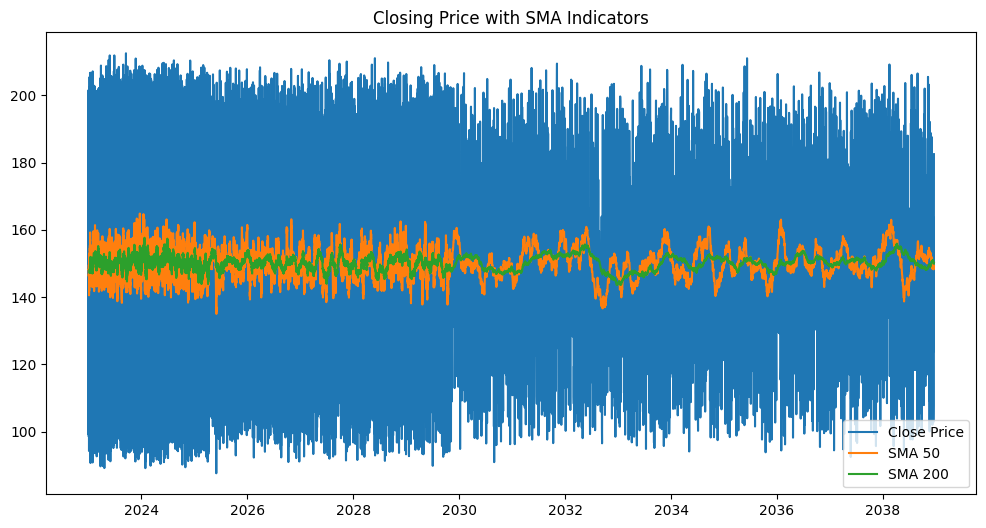

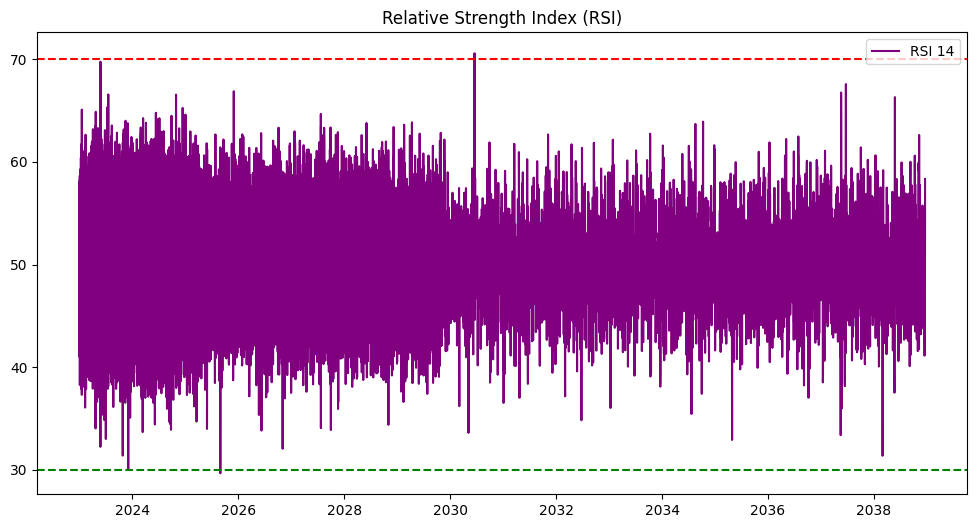

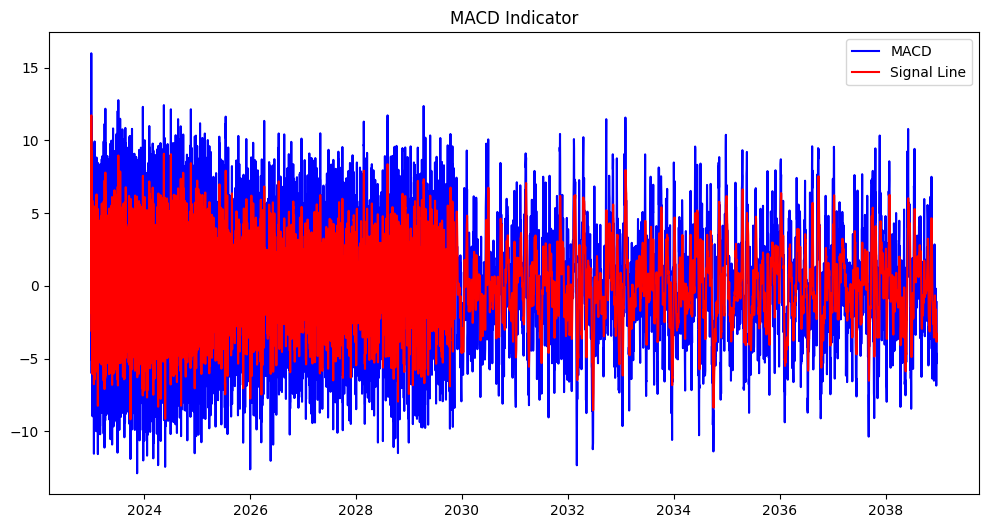

In [4]:

# Calculate SMA for 50 and 200 periods
data['SMA_50'] = data['close'].rolling(window=50).mean()
data['SMA_200'] = data['close'].rolling(window=200).mean()

# Calculate EMA for 50 periods
data['EMA_50'] = data['close'].ewm(span=50, adjust=False).mean()

def calculate_rsi(df, period=14):
    delta = df['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI_14'] = calculate_rsi(data)

# Calculate MACD line, Signal line, and MACD histogram
data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()


# Display the first few rows with calculated indicators
print("SMA and EMA calculations:")
print(data[['close', 'SMA_50', 'SMA_200', 'EMA_50']].head(10))

print("\nRSI calculations:")
print(data[['close', 'RSI_14']].head(10))

print("\nMACD calculations:")
print(data[['close', 'MACD', 'Signal_Line']].head(10))

# Ensure there are no NaN values after calculation
print("\nMissing values after calculations:")
print(data.isnull().sum())


import matplotlib.pyplot as plt
%matplotlib inline
# Plot the closing price with SMA
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Close Price')
plt.plot(data['SMA_50'], label='SMA 50')
plt.plot(data['SMA_200'], label='SMA 200')
plt.title('Closing Price with SMA Indicators')
plt.legend()
plt.show()

# Plot RSI
plt.figure(figsize=(12, 6))
plt.plot(data['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.show()

# Plot MACD
plt.figure(figsize=(12, 6))
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD Indicator')
plt.legend()
plt.show()


Basic Statistics:
               open          high           low         close        volume  \
count  39171.000000  39171.000000  39171.000000  39171.000000  39171.000000   
mean     150.020429    160.160315    139.943866    150.073291   3002.909219   
std       28.961543     29.516733     29.504386     29.348467   1153.482621   
min       94.565614     99.373526     76.994878     87.633355   1000.000000   
25%      124.917880    135.177462    114.992598    124.989853   2007.000000   
50%      149.979740    160.068345    139.947645    149.981924   2999.000000   
75%      175.025505    185.263277    164.913074    175.199774   4005.000000   
max      205.084897    225.412121    202.697905    212.498252   4999.000000   

             SMA_50       SMA_200        EMA_50        RSI_14        EMA_12  \
count  39122.000000  38972.000000  39171.000000  39158.000000  39171.000000   
mean     150.078590    150.080428    150.042810     50.006856    150.068152   
std        4.109151      2.050652

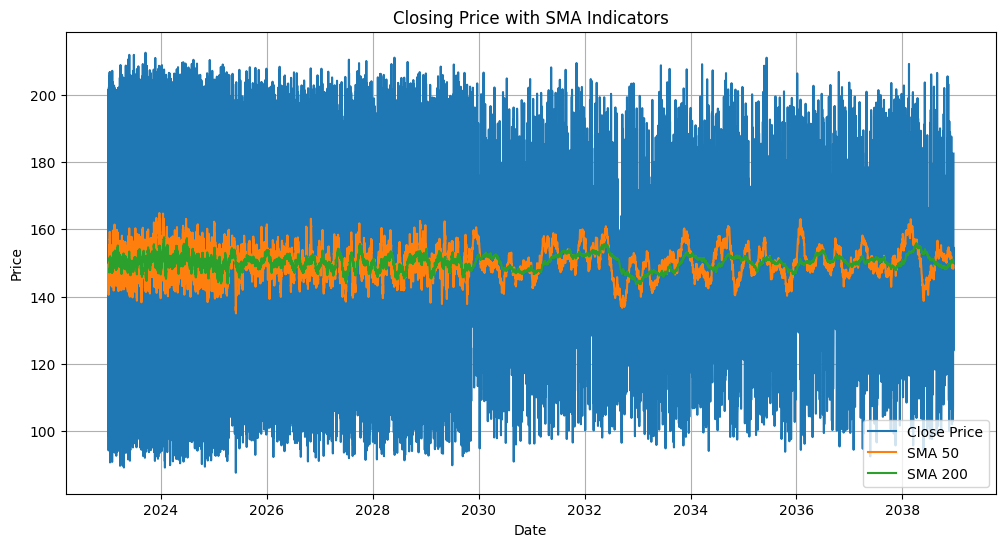

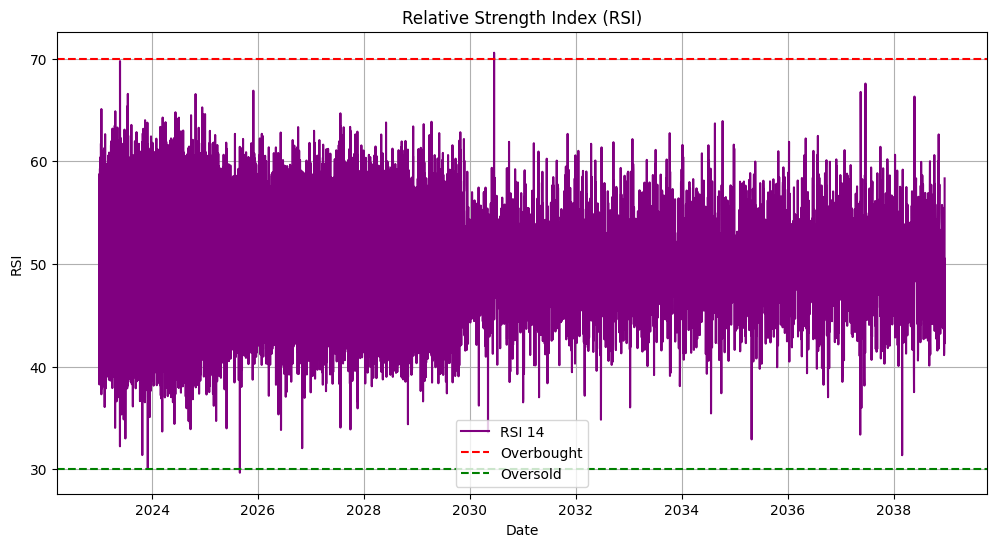

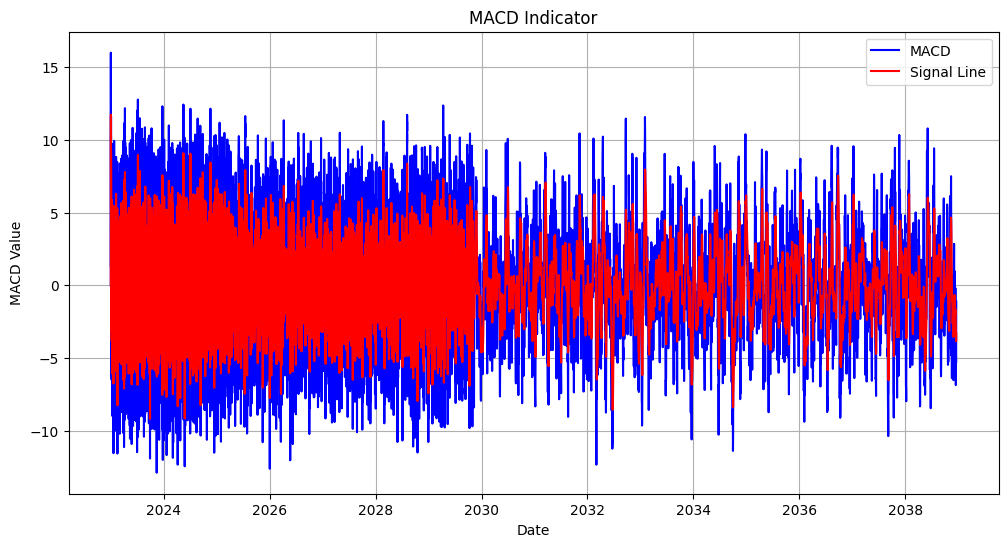

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic statistics
print("Basic Statistics:")
print(data.describe())

# Display the first few rows
print("\nSample Data:")
print(data.head())

# Plot the closing price with SMA
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Close Price')
plt.plot(data['SMA_50'], label='SMA 50')
plt.plot(data['SMA_200'], label='SMA 200')
plt.title('Closing Price with SMA Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Plot RSI
plt.figure(figsize=(12, 6))
plt.plot(data['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()

# Plot MACD
plt.figure(figsize=(12, 6))
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD Indicator')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid()
plt.show()


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


# Ensure data is sorted by datetime
data.sort_index(inplace=True)

# Display basic info
print("Dataset Loaded. Sample Data:")
print(data.head())

# Drop any missing values
data.dropna(inplace=True)

Dataset Loaded. Sample Data:
                           open        high         low       close  volume
datetime                                                                   
2023-01-01 00:00:00  102.465368  124.683850   99.389710   99.389710    4896
2023-01-01 01:00:00  120.062725  139.836260  110.927153  130.660712    3777
2023-01-01 02:00:00  126.643071  142.902703  115.013627  127.647019    2392
2023-01-01 03:00:00  155.378676  159.974706  133.775010  150.436902    2029
2023-01-01 04:00:00  112.737700  124.964543  100.490164  104.791538    3415


In [11]:
# Check for missing values in features
print("Missing values in features before PCA:")
print(data[features].isnull().sum())

# Drop rows with missing values in the feature columns used for PCA
data.dropna(subset=features, inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
data['pca_1'] = principal_components[:, 0]
data['pca_2'] = principal_components[:, 1]

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Prepare dataset for machine learning
data['target'] = (data['close'].shift(-1) > data['close']).astype(int)  # 1 if price goes up, 0 if down

# Feature selection
X = data[['SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'pca_1', 'pca_2']]
y = data['target']

# Split dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
accuracy = rf_model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Predict trading signals
data['rf_signal'] = rf_model.predict(X)

# Display the last few rows with predicted signals
print(data[['close', 'rf_signal']].tail(10))


Missing values in features before PCA:
SMA_50      0
SMA_200     0
EMA_50      0
EMA_200     0
RSI_14     13
MACD        0
dtype: int64
Explained Variance Ratio: [0.53215512 0.25427103]
Model Accuracy: 0.68
                 close  rf_signal
datetime                         
2188-11-01  183.935686          0
2188-12-01  162.770014          0
2189-01-01  119.658098          1
2189-02-01  142.294922          0
2189-03-01  112.491701          0
2189-04-01   91.880091          1
2189-05-01  103.440679          1
2189-06-01  180.973720          0
2189-07-01  102.175383          1
2189-08-01  140.750520          0


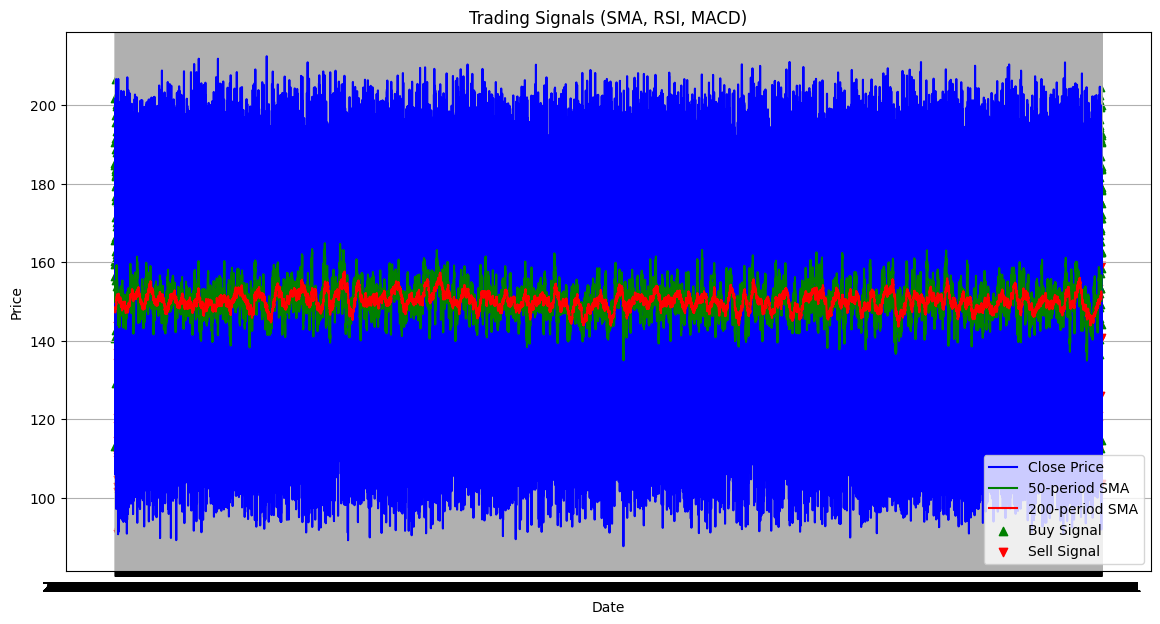

In [13]:
import matplotlib.pyplot as plt

# Plot closing price with SMA crossover signals
plt.figure(figsize=(14, 7))
plt.plot(data['close'], label='Close Price', color='blue')
plt.plot(data['SMA_50'], label='50-period SMA', color='green')
plt.plot(data['SMA_200'], label='200-period SMA', color='red')

buy_signals = data[data['final_signal'] > 0]
sell_signals = data[data['final_signal'] < 0]

plt.scatter(buy_signals.index, buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1)

plt.title('Trading Signals (SMA, RSI, MACD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

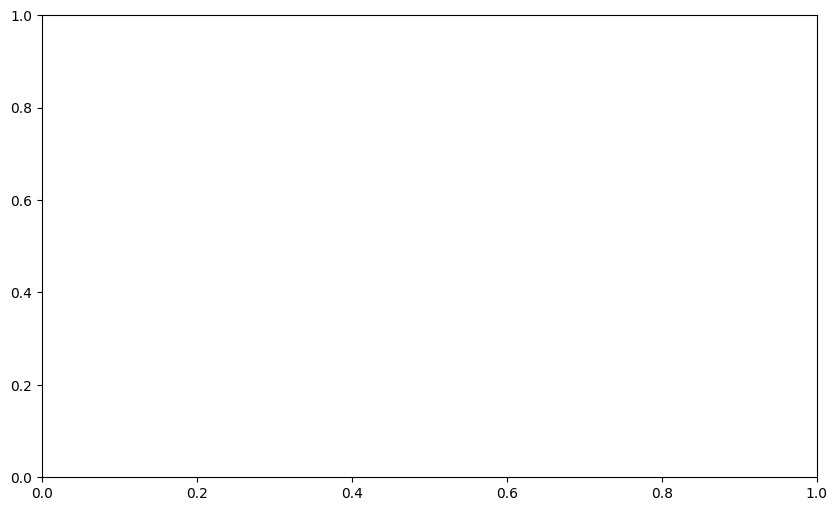

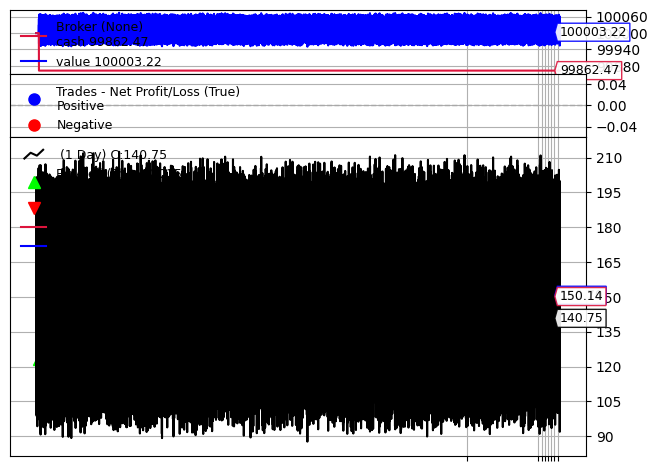

In [23]:
%matplotlib inline
import backtrader as bt
import logging
import pandas as pd
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# BackTrader strategy class
class TradingStrategy(bt.Strategy):
    params = (
        ('sma_short', 50),
        ('sma_long', 200),
    )

    def __init__(self):
        # Indicators
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_short)
        self.sma_long = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_long)

    def next(self):
        # Entry conditions
        if not self.position:
            if self.sma_short[0] > self.sma_long[0]:
                self.buy()
            elif self.sma_short[0] < self.sma_long[0]:
                self.sell()

# Load your existing `data` object (assumed to be a DataFrame)
# data = ... (you need to define your `data` object here based on previous steps)

# Fix the datetime index by inferring mixed formats
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index, errors='coerce')

# Drop rows with invalid datetime values (if any exist)
data.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)

# Initialize BackTrader and add the data
cerebro = bt.Cerebro()
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy and set broker settings
cerebro.addstrategy(TradingStrategy)
cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission=0.004)

# Run backtest
logger.info(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
logger.info(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
cerebro.plot(iplot=False, volume=False, show=False, ax=ax)
plt.show()
initial_capital = 100000  # Starting capital
final_value = data['close'].iloc[-1]  # Final portfolio value based on closing price


In [27]:
initial_capital = 100000  # Starting capital
final_value = data['close'].iloc[-1]  # Final portfolio value based on closing price

# Calculate performance metrics
return_rate = ((final_value - initial_capital) / initial_capital) * 100

# Calculate running maximum and drawdown
data['cummax'] = data['close'].cummax()
data['drawdown'] = (data['close'] - data['cummax']) / data['cummax']
max_drawdown = data['drawdown'].min() * 100

# Calculate daily returns
data['daily_return'] = data['close'].pct_change()

# Calculate Sharpe Ratio
risk_free_rate = 0.03  # Assuming a risk-free rate of 3%
excess_return = data['daily_return'].mean() - (risk_free_rate / 252)
sharpe_ratio = excess_return / data['daily_return'].std() * np.sqrt(252)

# Calculate Win Rate (assuming a 'profit' column exists)
if 'profit' not in data.columns:
    data['profit'] = data['close'].diff().fillna(0)  # Simulate profit/loss data
winning_trades = data[data['profit'] > 0].shape[0]
total_trades = data.shape[0]
win_rate = (winning_trades / total_trades) * 100

# Tabularize results
metrics = {
    "Return Rate (%)": f"{return_rate:.2f}%",
    "Maximum Drawdown (%)": f"{max_drawdown:.2f}%",
    "Sharpe Ratio": f"{sharpe_ratio:.2f}",
    "Win Rate (%)": f"{win_rate:.2f}%"
}

print("\nPerformance Metrics")
print("=" * 30)
for metric, value in metrics.items():
    print(f"{metric:<25} {value}")
print("=" * 30)



Performance Metrics
Return Rate (%)           -99.86%
Maximum Drawdown (%)      -58.76%
Sharpe Ratio              2.18
Win Rate (%)              49.97%
